https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [6]:
import numpy as np

In [7]:
def sample_points(k):
    x = np.random.rand(k,50)
    y = np.random.choice([0, 1], size=k, p=[.5, .5]).reshape([-1,1])
    return x,y

In [8]:
x, y = sample_points(10)
print(x[0])
print (y[0])

[7.95972614e-01 8.48107370e-01 6.47386272e-01 7.06353179e-01
 5.87473990e-01 2.47864261e-01 2.82987526e-01 8.50159013e-01
 6.78428903e-01 7.93338760e-02 3.55901660e-01 6.31188833e-01
 3.99913113e-01 6.48675650e-01 7.99554733e-02 7.66571846e-01
 2.60828990e-01 6.90342819e-01 1.73529401e-01 4.54818685e-01
 4.25238281e-01 3.50340266e-01 1.58187462e-01 6.63597705e-01
 1.23496206e-01 6.95046593e-01 1.38960270e-04 1.90821870e-01
 2.81767459e-01 1.20139603e-02 7.04415836e-01 1.06029338e-01
 7.92881938e-01 5.85293102e-01 9.24370497e-01 4.66876471e-01
 6.04060428e-01 5.41090501e-01 7.79214305e-01 4.36870727e-01
 9.32649300e-01 9.24259661e-01 8.86286342e-01 9.73336358e-02
 8.89688678e-01 7.32974142e-01 2.51351520e-02 2.23434998e-01
 5.90726711e-01 1.84157393e-01]
[0]


In [9]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('drive/MyDrive/data/Eximbank.csv')
df1=df.reset_index()['Close']
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [10]:
X_train.shape
y_train.shape

(1074,)

In [11]:
class MAML(object):
    def __init__(self):

        #initialize number of tasks i.e number of tasks we need in each batch of tasks
        self.num_tasks = 10

        #number of samples i.e number of shots  -number of data points (k) we need to have in each task
        self.num_samples = 10

        #number of epochs i.e training iterations
        self.epochs = 10000

        #hyperparameter for the inner loop (inner gradient update)
        self.alpha = 0.0001

        #hyperparameter for the outer loop (outer gradient update) i.e meta optimization
        self.beta = 0.0001

        #randomly initialize our model parameter theta
        self.theta = X_train

    #define our sigmoid activation function
    def sigmoid(self,a):
        return 1.0 / (1 + np.exp(-a))


    #now let us get to the interesting part i.e training :P
    def train(self):

        #for the number of epochs,
        for e in range(self.epochs):

            self.theta_ = []

            #for task i in batch of tasks
            for i in range(self.num_tasks):

                #sample k data points and prepare our train set
                XTrain, YTrain = sample_points(self.num_samples)

                a = np.matmul(XTrain, self.theta)

                YHat = self.sigmoid(a)

                #since we are performing classification, we use cross entropy loss as our loss function
                loss = ((np.matmul(-YTrain.T, np.log(YHat)) - np.matmul((1 -YTrain.T), np.log(1 - YHat)))/self.num_samples)[0][0]

                #minimize the loss by calculating gradients
                gradient = np.matmul(XTrain.T, (YHat - YTrain)) / self.num_samples

                #update the gradients and find the optimal parameter theta' for each of tasks
                self.theta_.append(self.theta - self.alpha*gradient)


            #initialize meta gradients
            meta_gradient = np.zeros(self.theta.shape)

            for i in range(self.num_tasks):

                #sample k data points and prepare our test set for meta training
                XTest, YTest = sample_points(10)

                #predict the value of y
                a = np.matmul(XTest, self.theta_[i])

                YPred = self.sigmoid(a)

                #compute meta gradients
                meta_gradient += np.matmul(XTest.T, (YPred - YTest)) / self.num_samples


            #update our randomly initialized model parameter theta with the meta gradients
            self.theta = self.theta-self.beta*meta_gradient/self.num_tasks

            if e%1000==0:
                print ("Epoch {}: Loss {}\n".format(e,loss)   )
                print ('Updated Model Parameter Theta\n')
                print ('Sampling Next Batch of Tasks \n')
                print ('---------------------------------\n')
    def predict(self, X_test):
      # Thực hiện dự đoán
      self.theta = np.random.normal(size=(1, X_train.shape[1]))
      a = np.matmul(X_test, self.theta)
      Y_pred = self.sigmoid(a)
      return Y_pred.flatten()


    # def predict(self, X_test):
    #   # Đảm bảo kích thước của theta phù hợp với số cột của X_test
    #   theta_reshaped = self.theta.reshape(1, -1)
    #   # Thực hiện dự đoán
    #   a = np.matmul(X_test, theta_reshaped.T)
    #   Y_pred = self.sigmoid(a)
    #   return Y_pred.flatten()  # Hoặc Y_pred.squeeze() để loại bỏ các chiều có kích thước 1






In [12]:
model = MAML()


In [13]:
model = MAML()
model.train()

Epoch 0: Loss [1.0489391]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 1000: Loss [0.90101098]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 2000: Loss [1.20045051]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 3000: Loss [0.86919165]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 4000: Loss [0.69760431]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 5000: Loss [0.81386537]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 6000: Loss [0.7239445]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

---------------------------------

Epoch 7000: Loss [0.78279272]

Updated Model Parameter Theta

Sampling Next Batch of Tasks 

----------------

In [14]:
# Dự đoán cho tập test
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
predictions = model.predict(test_data_reshaped)
predictions = predictions.reshape(predictions.shape[0], -1)

predictions = predictions[:len(test_data)]



In [15]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
predictions

array([[17792.76897729],
       [19020.45807583],
       [21657.19666119],
       [19911.16798382],
       [20256.95730284],
       [18233.29785379],
       [19259.99516245],
       [14826.10702076],
       [22127.97661657],
       [16935.73654133],
       [15440.48767842],
       [23321.45777682],
       [23377.92381365],
       [15693.9325635 ],
       [20922.95895417],
       [21402.46662851],
       [19828.87153288],
       [18478.96465234],
       [24308.91111413],
       [20181.82120444],
       [18874.20803683],
       [20204.12284816],
       [16429.52156978],
       [19253.38357221],
       [20626.67867605],
       [18384.24629184],
       [18197.39927569],
       [19494.03265144],
       [18245.96394299],
       [22518.1733052 ],
       [20061.71712587],
       [16334.38280956],
       [21009.81860898],
       [17736.73618736],
       [19332.0299889 ],
       [15182.7432407 ],
       [17617.86875947],
       [24154.91669285],
       [23109.64492114],
       [17620.70346952],


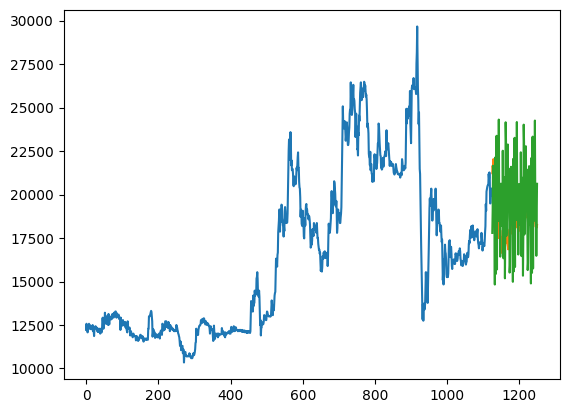

In [16]:
# 14.Vẽ hình
import matplotlib.pyplot as plt

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,predictions)


In [17]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 65)

In [19]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=65
i=0
while(i<30):

    if(len(temp_input)>65):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input)
        print(yhat[0])
        temp_input.append(yhat[0])
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 65)
0.5973230836701191
66
1 day input [0.41697989 0.43251188 0.41180255 0.40403656 0.40144789 0.40662522
 0.41180255 0.43251188 0.42474588 0.44286654 0.45063253 0.4532212
 0.44804387 0.44804387 0.44804387 0.40921389 0.39109323 0.41180255
 0.41956855 0.41180255 0.41180255 0.40921389 0.40921389 0.40921389
 0.41439122 0.41439122 0.41956855 0.43768921 0.44286654 0.44286654
 0.44027787 0.42992321 0.4532212  0.49463984 0.48687385 0.4609872
 0.47393052 0.46357586 0.49205118 0.49722851 0.48169652 0.47910785
 0.48428518 0.47393052 0.45839853 0.46616453 0.43510054 0.42733455
 0.41956855 0.43768921 0.43251188 0.43251188 0.44804387 0.44027787
 0.43768921 0.42992321 0.43768921 0.43251188 0.41439122 0.40403656
 0.40662522 0.41180255 0.40144789 0.40921389 0.59732308]
1 day output [0.56744473 0.3127296  0.69293374 ... 0.52719218 0.71565989 0.3340258 ]
2 day input [0.43251188 0.41180255 0.40403656 0.40144789 0.40662522 0.41180255
 0.43251188 0.42474588 0.44286654 0.45063253 0.4532212  0.44804387
 0

In [20]:
lst_output = np.array(lst_output)
lst_output = lst_output[:30]
lst_output = lst_output.reshape(lst_output.shape[0], -1)

lst_output.shape

(30, 1)

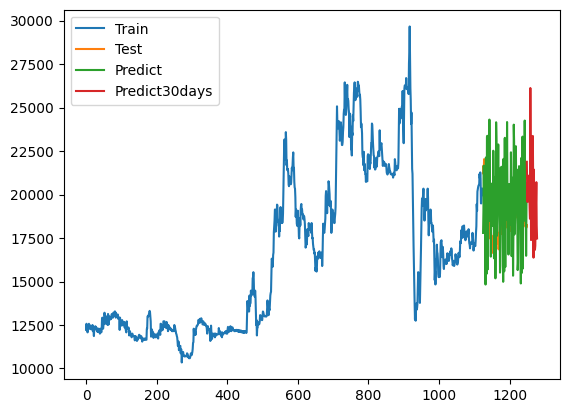

In [21]:
# 14.Vẽ hình
import matplotlib.pyplot as plt

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,predictions)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()


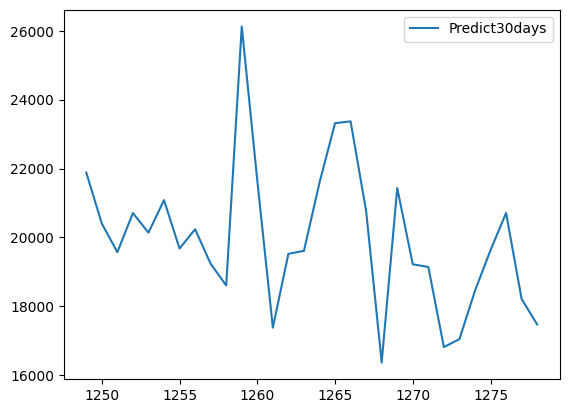

In [22]:
# 14.Vẽ hình
# Dự đoán 30 ngày tiếp theo
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Predict30days'])
plt.show()

In [23]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((predictions - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - predictions)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(predictions - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 2788.909904376083
Testing MAPE: 12.125033421591963
Testing MAE: 2263.9608013251664
